---
# **Introduction to Deep Learning Chapter 1**
---


## **Install libraries and tools**
**Execute this code beforehand**

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# A small package to create visualizations of PyTorch execution graphs and traces.
# https://github.com/szagoruyko/pytorchviz
!pip install torchviz | tail -n 1
from torchviz import make_dot  # visualize the PyTorch models

# Torchinfo provides information complementary to what is provided by print(your_model) in PyTorch, 
# similar to Tensorflow's model.summary() API to view the visualization of the model,
# which is helpful while debugging your network.
# https://github.com/TylerYep/torchinfo
!pip install torchinfo | tail -n 1
from torchinfo import summary  # display the summary of PyTorch models

# Set random seed (reproduce the same results every time)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True


## **Device allocation**
**Execute this code beforehand**

In [ ]:
# Device allocation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## **Check GPU status**

In [ ]:
!nvidia-smi

Fri Jan 20 15:45:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **define utility functions**
**Execute this code beforehand.**

This section defines some utility functions. Check the implementation of these functions as necessary.

In [ ]:
# A function for learning process
def fit(model, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # import tqdm library (progress bar)
    from tqdm.notebook import tqdm

    start_epoch = len(history)
    end_epoch = start_epoch + num_epochs

    # training loop
    for i in range(start_epoch, end_epoch):
        train_acc, train_loss = 0, 0
        val_acc, val_loss = 0, 0
        n_train, n_test = 0, 0

        # minibatch loop　（Learing phase)
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device) # send inputs to GPU
            labels = labels.to(device) # send inputs to GPU
    
            n_train += len(labels)              # count the number of training data
            optimizer.zero_grad()               # gradient initialization
            outputs = model(inputs)             # [Step1] prediction(forward calculation)
            loss = criterion(outputs, labels)   # [Step2] loss calculation
            loss.backward()                     # [Step3] backward propabation
            optimizer.step()                    # [Step4] parameter update

            prediction = torch.max(outputs, 1)[1]            # predicted label
            train_loss += loss.item()                        # loss
            train_acc += (prediction == labels).sum().item() # accuracy

        # Validation phase
        model.eval()
        for inputs_test, labels_test in test_loader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            n_test += len(labels_test)          # count the number of test data
            outputs_test = model(inputs_test)                   # prediction(forward calculation)
            loss_test = criterion(outputs_test, labels_test)    # loss calculation
            prediction_test = torch.max(outputs_test, 1)[1]     # predected label

            val_loss +=  loss_test.item()   #loss
            val_acc +=  (prediction_test == labels_test).sum().item()  # accuracy

        # record loss and accuracy
        train_acc = train_acc / n_train
        val_acc = val_acc / n_test
        train_loss = train_loss / n_train
        val_loss = val_loss / n_test
        print (f'Epoch [{i+1}/{end_epoch}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([i+1 , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

    return history


def show_loss_and_accuracy_graph(history):
    # Check loss and accuracy
    print(f'Before learning: Loss: {history[0,3]:.5f} Accuracy: {history[0,4]:.5f}')
    print(f'After learning : Loss: {history[-1,3]:.5f} Accuracy: {history[-1,4]:.5f}')

    # Display learning curve (Loss)
    plt.rcParams['figure.figsize'] = (9,8)
    plt.plot(history[:,0], history[:,1], 'b', label='training')
    plt.plot(history[:,0], history[:,3], 'k', label='test')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('learning curve(loss)')
    plt.legend()
    plt.show()

    # Display learning curve (Accuracy)
    plt.rcParams['figure.figsize'] = (9,8)
    plt.plot(history[:,0], history[:,2], 'b', label='training')
    plt.plot(history[:,0], history[:,4], 'k', label='test')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('learning curve(accuracy)')
    plt.legend()
    plt.show()


def show_confusion_matrix(model, dataloader, class_names, device):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    y_pred = []
    y_true = []

    # iterate over test data
    for inputs_test, labels_test in dataloader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            
            outputs_test = model(inputs_test)     # prediction(forward calculation)
            prediction_test = torch.max(outputs_test, 1)[1].data.cpu().numpy()  # predected label
            y_pred.extend(prediction_test) # Save Prediction
            
            labels = labels_test.data.cpu().numpy()
            y_true.extend(labels) # Save Truth

    cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
    cmp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(cmap=plt.cm.Blues, ax=ax)


def show_misrecognizd_images(model, dataloader, img_shape, class_names, device):
    count = 0

    # Display 50 images with "correct label : prediction"
    plt.figure(figsize=(15, 20))
    for images, labels in dataloader:
        # obtain predicted labels
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        predicted = torch.max(outputs, 1)[1]

        for i in np.arange(images.shape[0]):
            image_np = images[i].numpy().copy() # Tensor to NumPy
            label = labels[i]
            pred = predicted[i]
            if (pred != label):
                ax = plt.subplot(10, 10, count+1)
                img = image_np.reshape(img_shape)
                if(len(img_shape) == 3):
                    img = np.transpose(img, (1, 2, 0)) # Change axis order (channel, row, column) -> (row, column, channel)
                img = (img + 1)/2   # Revert the range of values ​​from [-1,1] to [0,1]

                # show result
                plt.imshow(img, cmap='gray')
                ax.set_title(f'{class_names[label]}:{class_names[pred]}')
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                count += 1
                if count == 100:
                    break
        else:
            continue
        break

    plt.show()


def show_image(img, imgtype='np', cmap='gray', figsize=(10,6), vmin=None, vmax=None):
    if(imgtype == "tensor"):
        img = img.numpy()

    if(imgtype == "np" or imgtype == "tensor"):
        if(len(img.shape) == 3):
            img = np.transpose(img, (1, 2, 0)) # Change axis order (channel, row, column) -> (row, column, channel)        

    plt.figure(figsize=figsize)
    plt.imshow(img, cmap, vmin, vmax)
    plt.show()

def show_kernels(model, kernel_key, figsize=(20,1), subplotsize=16, img_max_num=48):
    kernels = np.array(model.state_dict()[kernel_key].cpu())
    kernel_num = kernels.shape[0]
    channel_num = kernels.shape[1]

    img_index = 0
    for k in range(kernel_num):
        for c in range(channel_num):
            if(img_index % subplotsize == 0):
                plt.show()
                plt.figure(figsize=figsize)

            plt.subplot(1, subplotsize, img_index % subplotsize + 1)
            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
            plt.title(f"k,c:{k},{c}")
            plt.imshow(kernels[k][c], cmap="gray")
            img_index += 1
            if(img_index >= img_max_num):
                break
        else:
            continue
        break

def feature_to_img(feature, nrow=4, img_width=1000):
    feature = feature.unsqueeze(1)  # (N, H, W) -> (N, C, H, W)
    img = torchvision.utils.make_grid(feature.cpu(), nrow=nrow, normalize=True, pad_value=1)     # make images and arrange in a grid
    img = transforms.functional.to_pil_image(img)    # tensor to  PIL Image
    img_height = int(img_width * img.height / img.width)  # resize
    img = img.resize((img_width, img_height))
    return img

def show_features(features, nrow=10):
    for name, x in features.items():
        img = feature_to_img(feature=x, nrow=nrow)
        print(name, x.shape)
        display(img)

---
# **Multiclass classification of MNIST using MLP**
---

## **Example 1.1.1** Data Preparation (1) Dataset and Transforms

In [ ]:
import torchvision.datasets as datasets         # for using MNIST dataset
import torchvision.transforms as transforms     # Transforms

data_root = './data'  # Download destination folder

# preprocessing function (Transforms)
# MLP: Multi Layer Perceptron
transform_for_MLP = transforms.Compose([
    # ToTensor method transforms from PIL Image or numpy.ndarrya to torch.Tensor.
    # It also normalizes from [0, 255] integer values to [0.0, 1.0] float values.
    # see https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
    transforms.ToTensor(),

    # serialize (convert to 1st order tensor)
    transforms.Lambda(lambda x: x.view(-1)),   # 2-dim [28,28] tensor to 1-dim [768] tensor
])

# training dataset
# Built-int datasets: https://pytorch.org/vision/stable/datasets.html
train_set_MNIST = datasets.MNIST(
    root = data_root,
    train = True,       # for training
    download = True,
    transform = transform_for_MLP)

# test dataset
test_set_MNIST = datasets.MNIST(
    root = data_root,
    train = False,      # for testing
    download = True,
    transform = transform_for_MLP)

# class names of MNINST
#class_names_MNIST = datasets.MNIST.classes
class_names_MNIST = ['0','1','2','3','4','5','6','7','8','9']

print(train_set_MNIST.data.shape)
print(test_set_MNIST.data.shape)
print(class_names_MNIST)

# check the results of transforms
image, label = train_set_MNIST[0]
print('type of inputdata: ', type(image))
print('shpae of inputdata: ', image.shape)
print('type of label', type(label))
print('minimum value: ', image.data.min())
print('maximum value: ', image.data.max())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
type of inputdata:  <class 'torch.Tensor'>
shpae of inputdata:  torch.Size([784])
type of label <class 'int'>
minimum value:  tensor(0.)
maximum value:  tensor(1.)


## **Example 1.1.2** Data preparation (2) Dataloader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100  #minibatch size

# DataLoader for training data (with shuffle)
train_loader_MNIST = DataLoader( train_set_MNIST, batch_size = batch_size, shuffle = True)

# DataLoader for test data (without shuffle)
test_loader_MNIST = DataLoader( test_set_MNIST,  batch_size = batch_size, shuffle = False) 

## **Example 1.1.3** Model definition (Multi Layer Perceptron(MLP))

In [ ]:
import torch.nn as nn
import torch.optim as optim

# 3-layer neural network 
class Model_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 784  # input dimension = 784
        hidden_size = 64  # hidden size is a hyper parameter
        output_size = 10  # output dimension = 10 (the number of classes)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        # inplace = If set to True, the variable will be overwritten directly to save memory.
        #self.relu = nn.ReLU(inplace=True)　# Use ReLU
   
    def forward(self, x):
        p = self.linear1(x)
        y = self.sigmoid(p)
        #y = self.relu(p)
        q = self.linear2(y)
        return q

model_nlp = Model_MLP() # make model instance
model_nlp = model_nlp.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
optimizer = optim.SGD(model_nlp.parameters(), lr=0.01)  #lr = learning rate

# show model sumary
summary(model_nlp, (100,784))

Layer (type:depth-idx)                   Output Shape              Param #
Model_MLP                                [100, 10]                 --
├─Linear: 1-1                            [100, 64]                 50,240
├─Sigmoid: 1-2                           [100, 64]                 --
├─Linear: 1-3                            [100, 10]                 650
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
Total mult-adds (M): 5.09
Input size (MB): 0.31
Forward/backward pass size (MB): 0.06
Params size (MB): 0.20
Estimated Total Size (MB): 0.58

## **Example 1.1.4** Learning with MLP model

In [ ]:
num_epochs = 20    # The number of learning loop
history = np.zeros((0,5)) # For loss and accuracy recording
history = fit(model_nlp, optimizer, criterion, num_epochs, train_loader_MNIST, test_loader_MNIST, device, history)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.02232 acc: 0.34688 val_loss: 0.02140, val_acc: 0.49730


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.02012 acc: 0.55535 val_loss: 0.01845, val_acc: 0.63260


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.01673 acc: 0.66632 val_loss: 0.01479, val_acc: 0.71370


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.01336 acc: 0.74338 val_loss: 0.01176, val_acc: 0.77590


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.01081 acc: 0.78838 val_loss: 0.00963, val_acc: 0.81010


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00906 acc: 0.81520 val_loss: 0.00821, val_acc: 0.82920


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00787 acc: 0.83288 val_loss: 0.00722, val_acc: 0.84460


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00703 acc: 0.84410 val_loss: 0.00651, val_acc: 0.85730


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00641 acc: 0.85392 val_loss: 0.00597, val_acc: 0.86540


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00593 acc: 0.86145 val_loss: 0.00555, val_acc: 0.87160


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00555 acc: 0.86777 val_loss: 0.00521, val_acc: 0.87580


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00525 acc: 0.87320 val_loss: 0.00493, val_acc: 0.88230


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00499 acc: 0.87715 val_loss: 0.00470, val_acc: 0.88560


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00478 acc: 0.88055 val_loss: 0.00451, val_acc: 0.88780


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00459 acc: 0.88385 val_loss: 0.00434, val_acc: 0.89140


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00444 acc: 0.88665 val_loss: 0.00420, val_acc: 0.89330


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00430 acc: 0.88860 val_loss: 0.00407, val_acc: 0.89580


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00418 acc: 0.89073 val_loss: 0.00396, val_acc: 0.89670


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00407 acc: 0.89283 val_loss: 0.00387, val_acc: 0.89820


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00398 acc: 0.89410 val_loss: 0.00378, val_acc: 0.90100


## **Example 1.1.5** Check the loss and accuracy

Before learning: Loss: 0.02140 Accuracy: 0.49730
After learning : Loss: 0.00378 Accuracy: 0.90100


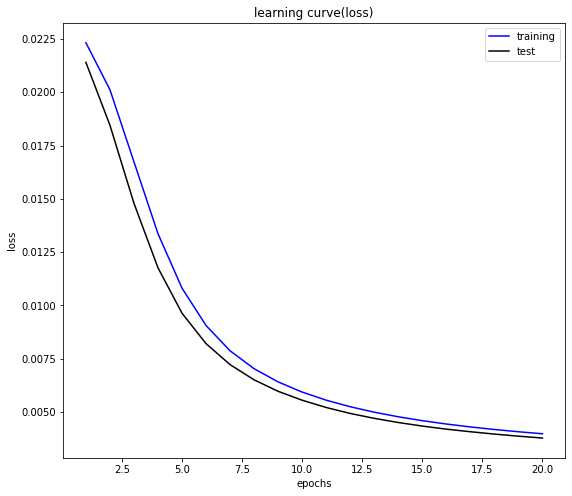

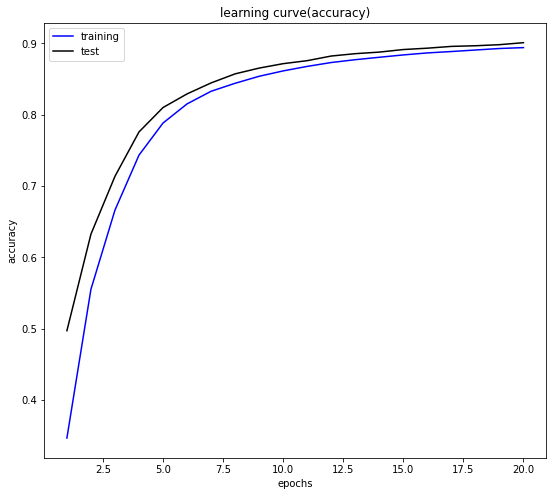

In [ ]:
show_loss_and_accuracy_graph(history)

## **Example 1.1.6** Show confusion matrix

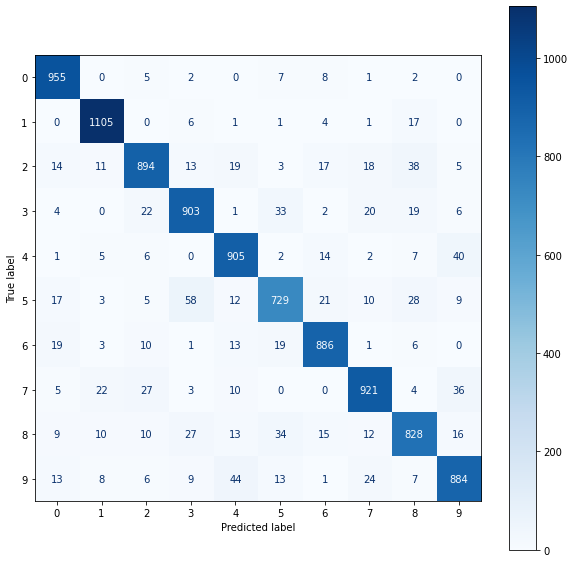

In [ ]:
show_confusion_matrix(model=model_nlp,
                      dataloader=test_loader_MNIST,
                      class_names=class_names_MNIST,
                      device=device)

## **Example 1.1.7** Show misrecognized images

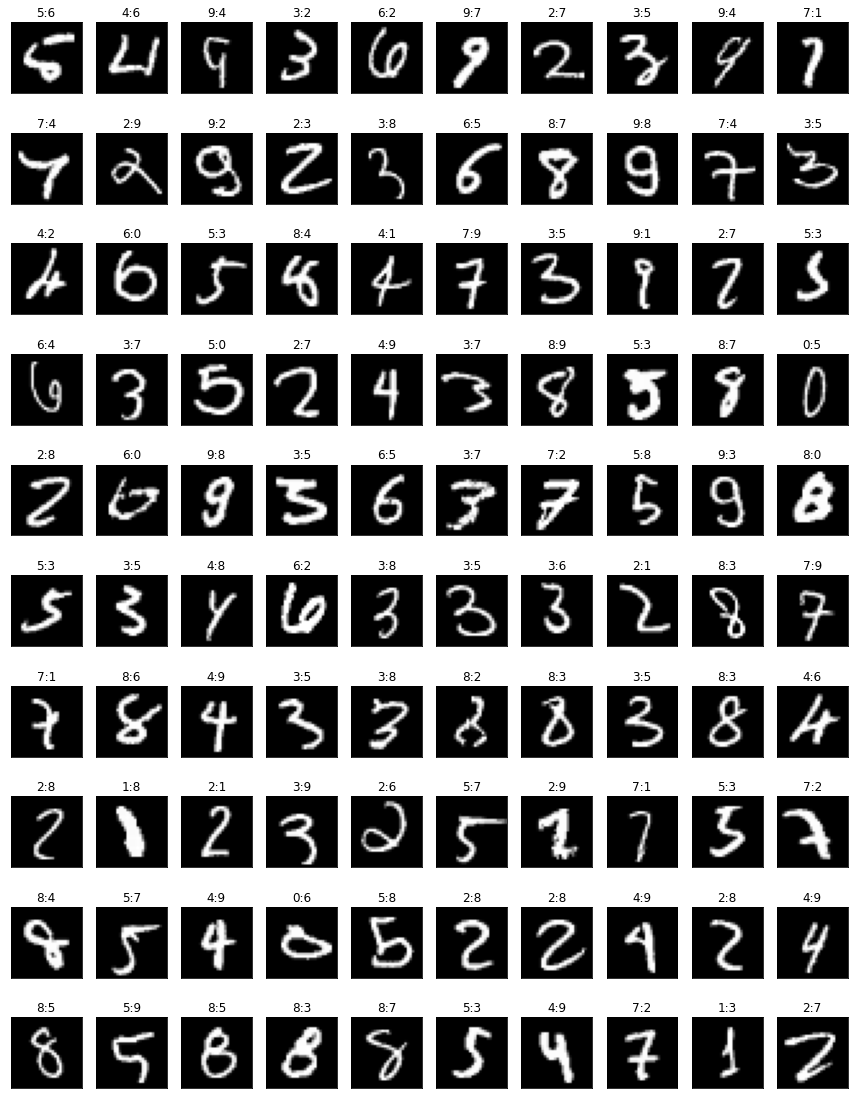

In [ ]:
show_misrecognizd_images(model=model_nlp,
                         dataloader=test_loader_MNIST,
                         img_shape=(28, 28),
                         class_names=class_names_MNIST,
                         device=device)

## 🤔**Exercise 1.1** Make MLP with more than 5 linear layers

And make sure that whether the network work well or not and report the final accuracy.


In [ ]:
import torch.nn as nn
import torch.optim as optim

# implement more than 5-layer neural network 
class Model_MLP2(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 784  # input dimension = 784
        hidden_size = 64  # hidden size is a hyper parameter
        output_size = 10  # output dimension = 10 (the number of classes)
        self.linear1 = nn.Linear(784, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 32)
        self.linear4 = nn.Linear(32, 32)
        self.linear5 = nn.Linear(32, 10)
        self.sigmoid = nn.Sigmoid()
   
    def forward(self, x):
      x = self.linear1(x)
      x = self.sigmoid(x)
      x = self.linear2(x)
      x = self.sigmoid(x)
      x = self.linear3(x)
      x = self.sigmoid(x)
      x = self.linear4(x)
      x = self.sigmoid(x)
      x = self.linear5(x)
      x = self.sigmoid(x)
      return x


model_nlp2 = Model_MLP2() # make model instance
model_nlp2 = model_nlp2.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# SDG (stochastic gradient descent)
optimizer = optim.SGD(model_nlp.parameters(), lr=0.01)  #lr = learning rate

# show model sumary
summary(model_nlp2, (100,784,))

Layer (type:depth-idx)                   Output Shape              Param #
Model_MLP2                               [100, 10]                 --
├─Linear: 1-1                            [100, 64]                 50,240
├─Sigmoid: 1-2                           [100, 64]                 --
├─Linear: 1-3                            [100, 32]                 2,080
├─Sigmoid: 1-4                           [100, 32]                 --
├─Linear: 1-5                            [100, 32]                 1,056
├─Sigmoid: 1-6                           [100, 32]                 --
├─Linear: 1-7                            [100, 32]                 1,056
├─Sigmoid: 1-8                           [100, 32]                 --
├─Linear: 1-9                            [100, 10]                 330
├─Sigmoid: 1-10                          [100, 10]                 --
Total params: 54,762
Trainable params: 54,762
Non-trainable params: 0
Total mult-adds (M): 5.48
Input size (MB): 0.31
Forward/backward pass s

In [ ]:
num_epochs = 20    # The number of learning loop
history = np.zeros((0,5)) # For loss and accuracy recording
history = fit(model_nlp, optimizer, criterion, num_epochs, train_loader_MNIST, test_loader_MNIST, device, history)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/20], loss: 0.00389 acc: 0.89568 val_loss: 0.00370, val_acc: 0.90210


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/20], loss: 0.00382 acc: 0.89692 val_loss: 0.00363, val_acc: 0.90330


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/20], loss: 0.00375 acc: 0.89855 val_loss: 0.00357, val_acc: 0.90310


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/20], loss: 0.00368 acc: 0.89985 val_loss: 0.00351, val_acc: 0.90390


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/20], loss: 0.00363 acc: 0.90040 val_loss: 0.00345, val_acc: 0.90490


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/20], loss: 0.00357 acc: 0.90160 val_loss: 0.00341, val_acc: 0.90610


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/20], loss: 0.00352 acc: 0.90238 val_loss: 0.00336, val_acc: 0.90620


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/20], loss: 0.00347 acc: 0.90347 val_loss: 0.00331, val_acc: 0.90760


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/20], loss: 0.00343 acc: 0.90430 val_loss: 0.00328, val_acc: 0.90720


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/20], loss: 0.00339 acc: 0.90530 val_loss: 0.00324, val_acc: 0.90840


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [11/20], loss: 0.00335 acc: 0.90587 val_loss: 0.00320, val_acc: 0.91000


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [12/20], loss: 0.00331 acc: 0.90707 val_loss: 0.00317, val_acc: 0.91090


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [13/20], loss: 0.00328 acc: 0.90780 val_loss: 0.00314, val_acc: 0.91130


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [14/20], loss: 0.00325 acc: 0.90817 val_loss: 0.00311, val_acc: 0.91180


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [15/20], loss: 0.00321 acc: 0.90933 val_loss: 0.00307, val_acc: 0.91290


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [16/20], loss: 0.00318 acc: 0.91008 val_loss: 0.00305, val_acc: 0.91370


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [17/20], loss: 0.00315 acc: 0.91028 val_loss: 0.00302, val_acc: 0.91470


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [18/20], loss: 0.00313 acc: 0.91120 val_loss: 0.00300, val_acc: 0.91510


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [19/20], loss: 0.00310 acc: 0.91138 val_loss: 0.00298, val_acc: 0.91580


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [20/20], loss: 0.00307 acc: 0.91235 val_loss: 0.00295, val_acc: 0.91540


Before learning: Loss: 0.00370 Accuracy: 0.90210
After learning : Loss: 0.00295 Accuracy: 0.91540


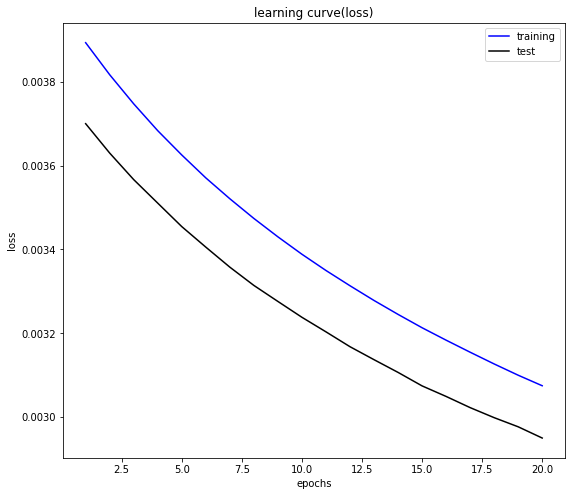

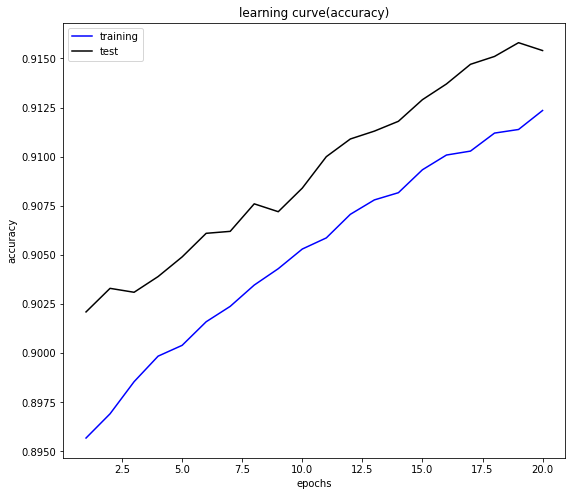

In [ ]:
show_loss_and_accuracy_graph(history)

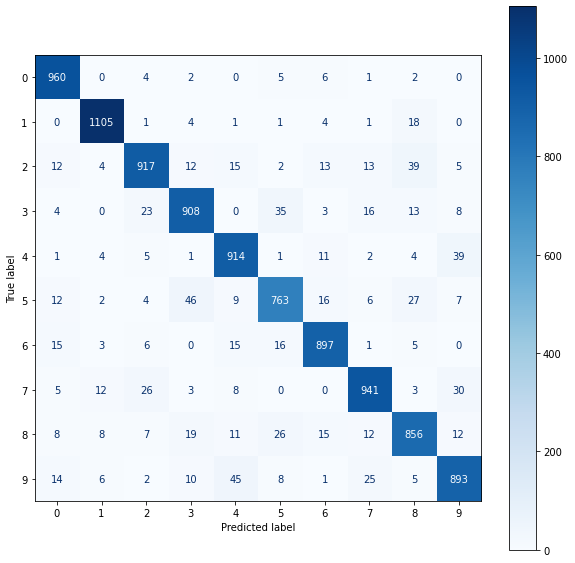

In [ ]:
show_confusion_matrix(model=model_nlp,
                      dataloader=test_loader_MNIST,
                      class_names=class_names_MNIST,
                      device=device)

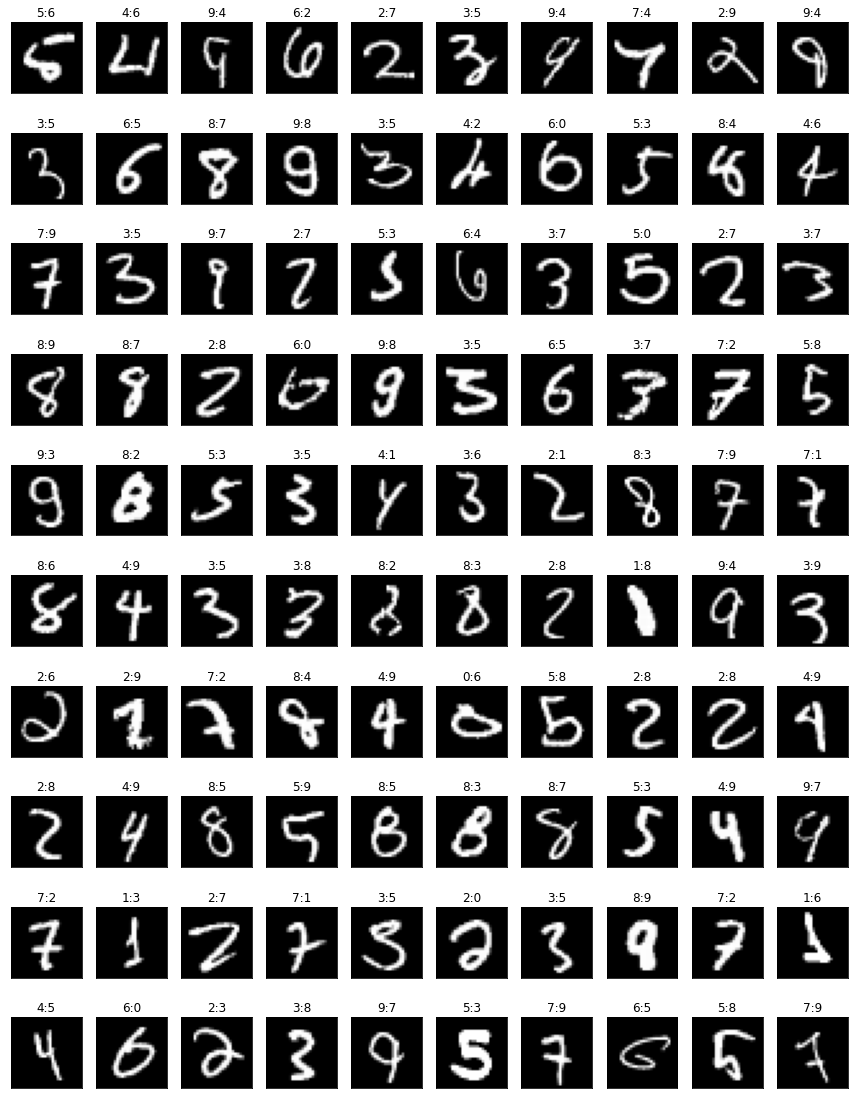

In [ ]:
show_misrecognizd_images(model=model_nlp,
                         dataloader=test_loader_MNIST,
                         img_shape=(28, 28),
                         class_names=class_names_MNIST,
                         device=device)

---
# **Multiclass classification of MNIST using CNN(1)**
---

## **Example 1.2.1** Data Preparation (1) Dataset and Transforms

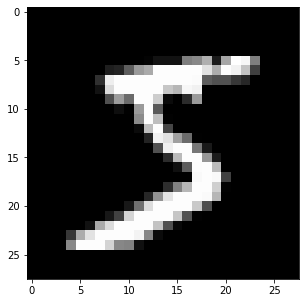

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
type of inputdata:  <class 'torch.Tensor'>
shpae of inputdata:  torch.Size([1, 28, 28])
minimum value:  tensor(-1.)
maximum value:  tensor(1.)


In [ ]:
import torchvision.datasets as datasets         # for using MNIST dataset
import torchvision.transforms as transforms     # Transforms

data_root = './data'  # Download destination folder

# preprocessing function (Transforms)
transform_for_CNN = transforms.Compose([
    # ToTensor method transforms from PIL Image or numpy.ndarrya to torch.Tensor.
    # It also normalizes from [0, 255] integer values to [0.0, 1.0] float values.
    # see https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
    transforms.ToTensor(),

    # serialize (convert to 1st order tensor)
    transforms.Normalize(0.5, 0.5)  # mean=0.5, std=0.5, image = (image - mean) / std
])

# training dataset
train_set_MNIST = datasets.MNIST(
    root = data_root,
    train = True,
    download = True,
    transform = transform_for_CNN)

# test dataset
test_set_MNIST = datasets.MNIST(
    root = data_root,
    train = False,
    download = True,
    transform = transform_for_CNN)

# class names of MNINST
#class_names_MNIST = datasets.MNIST.classes
class_names_MNIST = ['0','1','2','3','4','5','6','7','8','9']

# check the results of transforms
image, label = train_set_MNIST[0]

show_image(image.squeeze(), imgtype="tensor", figsize=(5,5), cmap="gray")

print(train_set_MNIST.data.shape)
print(test_set_MNIST.data.shape)
print('type of inputdata: ', type(image))
print('shpae of inputdata: ', image.shape)
print('minimum value: ', image.data.min())
print('maximum value: ', image.data.max())

## **Example 1.2.2** Data preparation (2) Dataloader

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100  #minibatch size

# DataLoader for training data (with shuffle)
train_loader_MNIST = DataLoader( train_set_MNIST, batch_size = batch_size, shuffle = True)

# DataLoader for test data (without shuffle)
test_loader_MNIST = DataLoader( test_set_MNIST,  batch_size = batch_size, shuffle = False) 

## **Example 1.2.3** Model definition (Model_CNN1)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Model_CNN1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=0)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=0)
        self.relu = nn.ReLU(inplace=True) # inplace = If set to True, the variable will be overwritten directly to save memory.
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(2304, 64)
        self.l2 = nn.Linear(64, 10)
        
        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool)
        
        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2)
   
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model_cnn1 = Model_CNN1()
model_cnn1 = model_cnn1.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer = optim.SGD(model_cnn1.parameters(), lr=0.01)  # SGD, lr = learning rate
optimizer = optim.Adam(model_cnn1.parameters(), lr=0.001) # Adam, lr = learning rate

summary(model_cnn1, (60000,1,28,28), depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
Model_CNN1                               [60000, 10]               --
├─Sequential: 1-1                        [60000, 16, 12, 12]       2,320
│    └─Conv2d: 2-1                       [60000, 16, 26, 26]       160
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [60000, 16, 26, 26]       --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [60000, 16, 24, 24]       2,320
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [60000, 16, 24, 24]       --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [60000, 16, 12, 12]       --
├─Flatten: 1-6                           [60000, 2304]             --
├─Sequential: 1-7                        [

## **Example 1.2.4** Learning with Model_CNN1

In [ ]:
num_epochs = 10    # The number of learning loop
history = np.zeros((0,5)) # For loss and accuracy recording
history = fit(model_cnn1, optimizer, criterion, num_epochs, train_loader_MNIST, test_loader_MNIST, device, history)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.00243 acc: 0.93053 val_loss: 0.00075, val_acc: 0.97600


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.00065 acc: 0.98093 val_loss: 0.00049, val_acc: 0.98410


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.00044 acc: 0.98655 val_loss: 0.00053, val_acc: 0.98270


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00033 acc: 0.98955 val_loss: 0.00042, val_acc: 0.98670


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00024 acc: 0.99223 val_loss: 0.00038, val_acc: 0.98700


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00021 acc: 0.99312 val_loss: 0.00042, val_acc: 0.98650


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00014 acc: 0.99550 val_loss: 0.00047, val_acc: 0.98650


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00012 acc: 0.99575 val_loss: 0.00041, val_acc: 0.98880


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00012 acc: 0.99618 val_loss: 0.00040, val_acc: 0.98870


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00009 acc: 0.99705 val_loss: 0.00054, val_acc: 0.98630


## **Example 1.2.5 Check the loss and accuracy**

Before learning: Loss: 0.00075 Accuracy: 0.97600
After learning : Loss: 0.00054 Accuracy: 0.98630


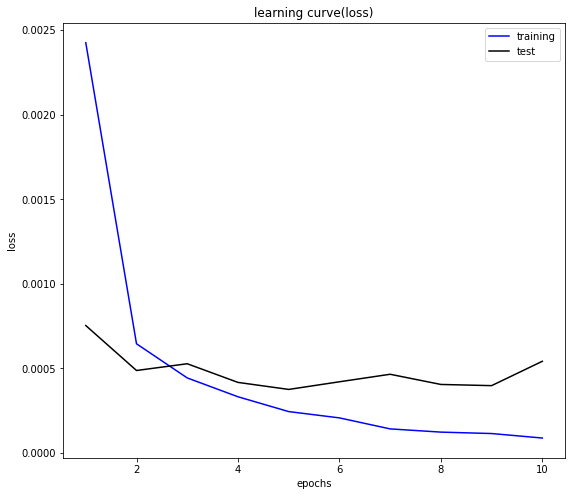

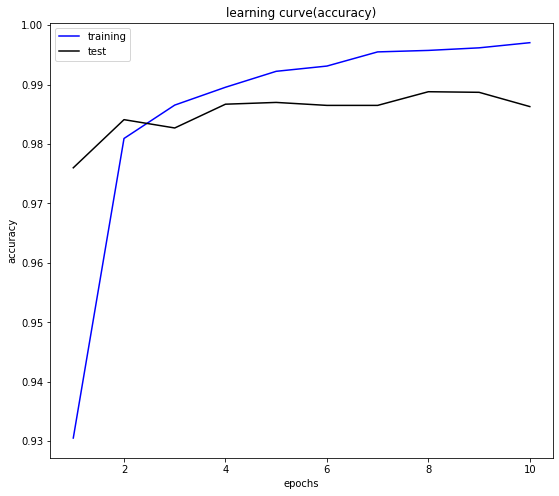

In [ ]:
show_loss_and_accuracy_graph(history)

## **Example 1.2.6 Show confusion matrix**

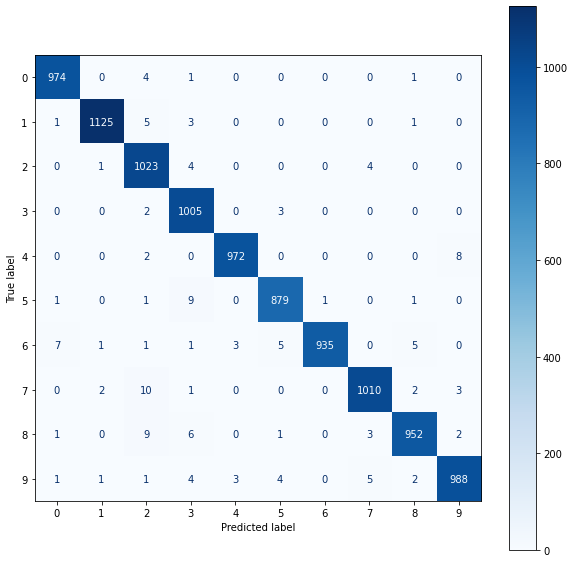

In [ ]:
show_confusion_matrix(model=model_cnn1,
                      dataloader=test_loader_MNIST,
                      class_names=class_names_MNIST,
                      device=device)

## **Example 1.2.7 Show misrecognized images**

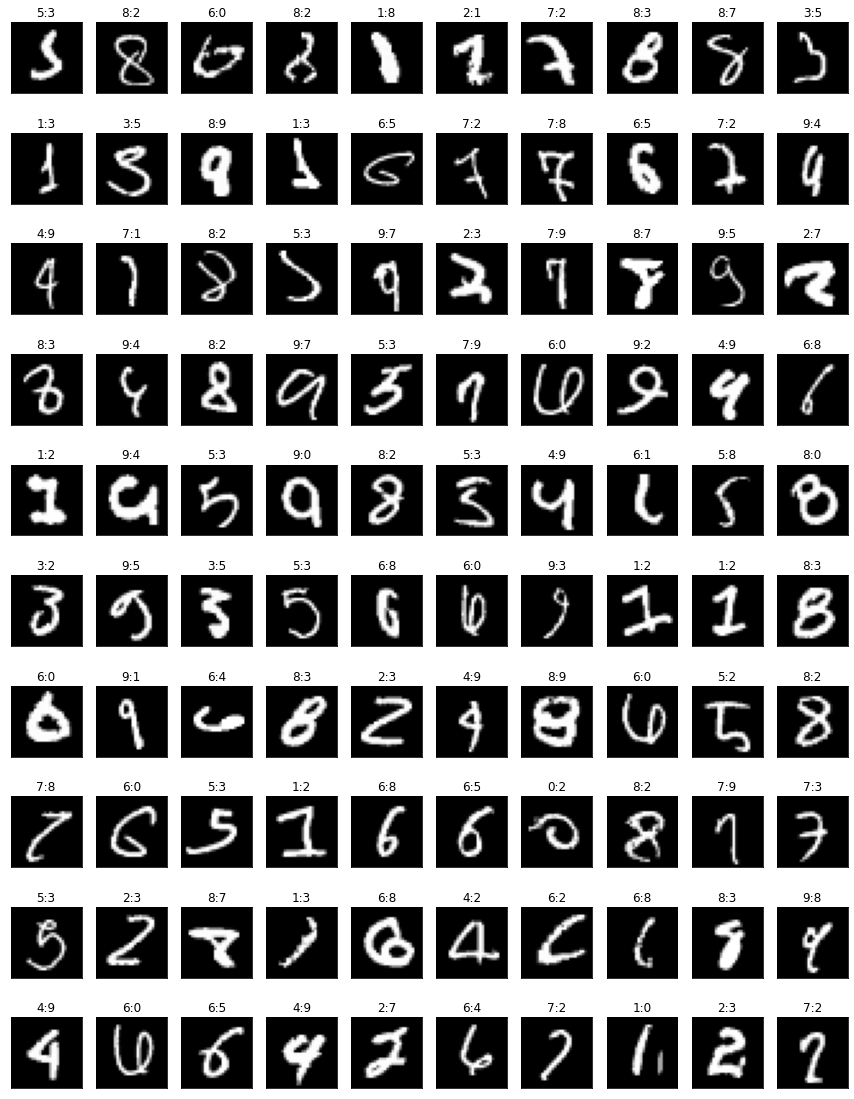

In [ ]:
show_misrecognizd_images(model=model_cnn1,
                         dataloader=test_loader_MNIST,
                         img_shape=(28, 28),
                         class_names=class_names_MNIST,
                         device=device)

## 🤔**Exercise 1.2** Make Model_CNN2 **後で消すこと**

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Model_CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.relu = nn.ReLU(inplace=True) # inplace = If set to True, the variable will be overwritten directly to save memory.
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 64)
        self.l2 = nn.Linear(64, 10)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu, 
            self.conv4,
            self.relu,
            self.maxpool)
        
        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2)
   
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model_cnn2 = Model_CNN2()
model_cnn2 = model_cnn2.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer = optim.SGD(model_cnn2.parameters(), lr=0.01)  # SGD, lr = learning rate
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.001) # Adam, lr = learning rate

summary(model_cnn2, (60000,1,28,28), depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
Model_CNN2                               [60000, 10]               --
├─Sequential: 1-1                        [60000, 16, 7, 7]         6,960
│    └─Conv2d: 2-1                       [60000, 16, 28, 28]       160
├─Sequential: 1-8                        --                        (recursive)
│    └─ReLU: 2-2                         [60000, 16, 28, 28]       --
├─Sequential: 1-9                        --                        (recursive)
│    └─Conv2d: 2-3                       [60000, 16, 28, 28]       2,320
├─Sequential: 1-8                        --                        (recursive)
│    └─ReLU: 2-4                         [60000, 16, 28, 28]       --
├─Sequential: 1-9                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [60000, 16, 14, 14]       --
│    └─Conv2d: 2-6                       [60000, 16, 14, 14]       2,320
├─Sequential: 1-8                      

In [ ]:
num_epochs = 5    # The number of learning loop
history = np.zeros((0,5)) # For loss and accuracy recording
history = fit(model_cnn2, optimizer, criterion, num_epochs, train_loader_MNIST, test_loader_MNIST, device, history)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.00280 acc: 0.90818 val_loss: 0.00061, val_acc: 0.97970


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00070 acc: 0.97898 val_loss: 0.00043, val_acc: 0.98500


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00050 acc: 0.98407 val_loss: 0.00041, val_acc: 0.98670


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00040 acc: 0.98728 val_loss: 0.00035, val_acc: 0.98820


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00033 acc: 0.98973 val_loss: 0.00040, val_acc: 0.98740


## 🤔**Exercise 1.3** Check the total params and validation accuracy


* Model_MLP
  * Total params: 50,890
  * val_acc: 0.90100
* Model_CNN1
  * Total params: 150,650
  * val_acc: 0.98900
* Model_CNN2
  * Total params: 58,010
  * val_acc: 0.99070

---
# **What the Convolution layer does**
---

## **Example 1.3.1** Download simple ox dataset

In [ ]:
import os
import urllib.request
import zipfile

data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "https://github.com/a-ymst/IntroductionToDeepLearning/raw/main/chapter1/xo_dataset.zip"
save_path = os.path.join(data_dir, "xo_dataset.zip")

if not os.path.exists(save_path):
    urllib.request.urlretrieve(url, save_path)

    # load zip file
    zip = zipfile.ZipFile(save_path)
    zip.extractall(data_dir)  # extrarct zip file
    zip.close()  # close zip file

    # delete zip file
    os.remove(save_path)

## **Example 1.3.2** Generating Feature Maps with Convolution

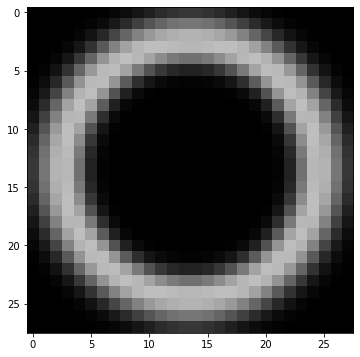

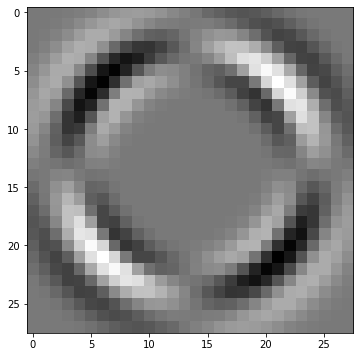

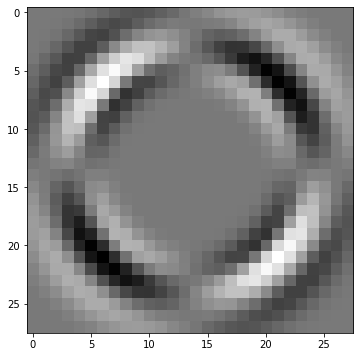

tensor([[[0.1882, 0.4431],
         [0.4451, 0.1902]],

        [[0.4431, 0.1882],
         [0.1902, 0.4451]]])
output: 1.0196077823638916


In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# 5 pics of circle: o1.png to o5.png
# 5 pics of cross: x1.png to x5.png 
file_name = "./data/xo_dataset/o1.png" 
img = Image.open(file_name)

show_image(img=img, imgtype="img", cmap="gray", figsize=(6,6))

# preprocessing function (Transforms)
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

x = transform(img)

### 1st convolution
filter1 = np.array([[[[ 1.0, -0.5, -0.5],
                      [-0.5,  1.0, -0.5],
                      [-0.5, -0.5,  1.0]]],
                    
                   [[[-0.5, -0.5,  1.0],
                     [-0.5,  1.0, -0.5],
                     [ 1.0, -0.5, -0.5]]]])

conv1 = nn.Conv2d(1, 2, 3, padding=1, bias=False)
conv1.weight.data = torch.tensor(filter1, dtype=torch.float32)

feature1 = conv1(x)
feature1 = feature1.detach() # to show as image

show_image(feature1[0], imgtype="tensor", cmap="gray", figsize=(6,6))
show_image(feature1[1], imgtype="tensor", cmap="gray", figsize=(6,6))

### Max pool
maxpool = nn.MaxPool2d(14)
feature2 = maxpool(feature1)
print(feature2)

### 2nd convolution
filter2 = np.array([[[[-1, 1],
                      [1, -1]],
                    
                     [[1, -1],
                      [-1, 1]]]])

conv2 = nn.Conv2d(2, 1, 2, padding=0, bias=False)
conv2.weight.data = torch.tensor(filter2, dtype=torch.float32)

output = conv2(feature2)
output_np = output.detach().numpy()

# This value represents the "circle-ish"
print("output:", float(output_np))


## **Example 1.3.3** Visualizing the kernels of Model_CNN

In [ ]:
print(model_cnn1)

Model_CNN1(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=2304, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


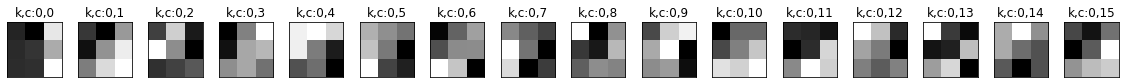

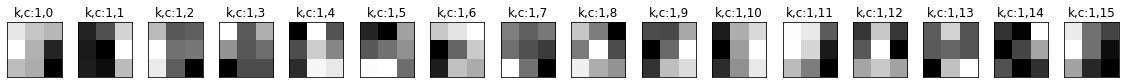

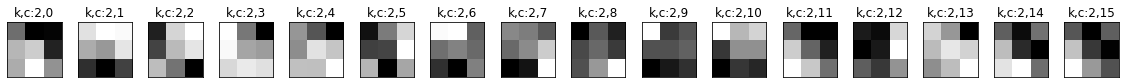

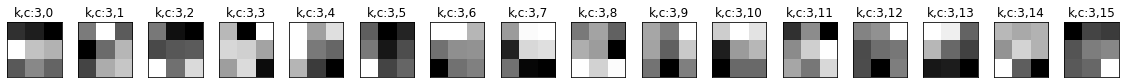

In [ ]:
show_kernels(model=model_cnn1, kernel_key="conv2.weight", img_max_num=64)

## **Example 1.3.4 Visualizing the feature maps of Model_CNN**

In [ ]:
import torchvision.models.feature_extraction as feature_extraction

layer_names = feature_extraction.get_graph_node_names(model_cnn1)
print(layer_names)

(['x', 'conv1', 'relu', 'conv2', 'relu_1', 'maxpool', 'flatten', 'l1', 'relu_2', 'l2'], ['x', 'conv1', 'relu', 'conv2', 'relu_1', 'maxpool', 'flatten', 'l1', 'relu_2', 'l2'])


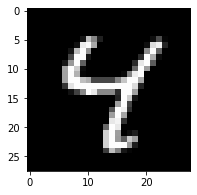

conv1 torch.Size([16, 26, 26])


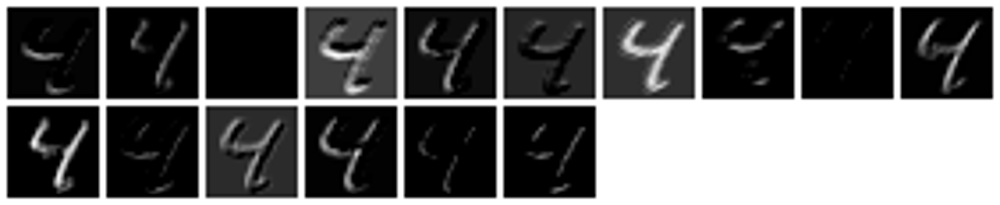

conv2 torch.Size([16, 24, 24])


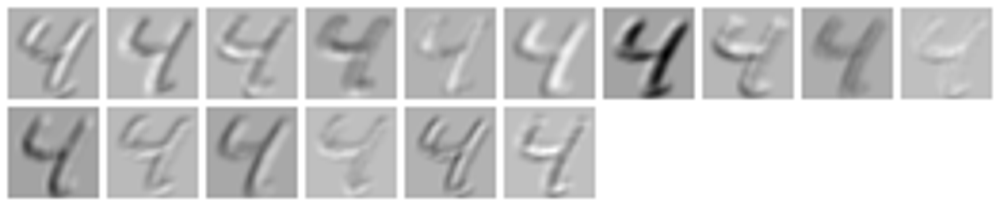

In [ ]:
input, label = test_set_MNIST[6]
input = (input + 1) / 2
show_image(input.squeeze(0), imgtype="tensor", figsize=(3,3))

extractor = feature_extraction.create_feature_extractor(model_cnn1, ["conv1", "conv2"])
features = extractor(input.to(device))

show_features(features)

## 🤔**Exercise 1.4** 

Implement a CNN model including a convolution layer with 9x9 kernels and train it with MNIST. Other network configurations can be freely designed, but the validation accuracy must be achieved 98% or higher.


After training, 

* (1) display the 9x9 kernels using show_kernels()
* (2) Input any one image, then display the feature maps using feature_extractor.


In [ ]:
import torch.nn as nn
import torch.optim as optim

class Model_CNN3(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 9, padding=4)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.relu = nn.ReLU(inplace=True) # inplace = If set to True, the variable will be overwritten directly to save memory.
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 64)
        self.l2 = nn.Linear(64, 10)

        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool,
            self.conv3,
            self.relu, 
            self.conv4,
            self.relu,
            self.maxpool)
        
        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2)
   
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model_cnn3 = Model_CNN3()
model_cnn3 = model_cnn3.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer = optim.SGD(model_cnn3.parameters(), lr=0.01)  # SGD, lr = learning rate
optimizer = optim.Adam(model_cnn3.parameters(), lr=0.001) # Adam, lr = learning rate

summary(model_cnn3, (60000,1,28,28), depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
Model_CNN3                               [60000, 10]               --
├─Sequential: 1-1                        [60000, 16, 7, 7]         6,960
│    └─Conv2d: 2-1                       [60000, 16, 28, 28]       1,312
├─Sequential: 1-8                        --                        (recursive)
│    └─ReLU: 2-2                         [60000, 16, 28, 28]       --
├─Sequential: 1-9                        --                        (recursive)
│    └─Conv2d: 2-3                       [60000, 16, 28, 28]       2,320
├─Sequential: 1-8                        --                        (recursive)
│    └─ReLU: 2-4                         [60000, 16, 28, 28]       --
├─Sequential: 1-9                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [60000, 16, 14, 14]       --
│    └─Conv2d: 2-6                       [60000, 16, 14, 14]       2,320
├─Sequential: 1-8                    

In [ ]:
num_epochs = 5    # The number of learning loop
history = np.zeros((0,5)) # For loss and accuracy recording
history = fit(model_cnn3, optimizer, criterion, num_epochs, train_loader_MNIST, test_loader_MNIST, device, history)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.00283 acc: 0.91115 val_loss: 0.00086, val_acc: 0.97200


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.00079 acc: 0.97533 val_loss: 0.00050, val_acc: 0.98370


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.00059 acc: 0.98217 val_loss: 0.00049, val_acc: 0.98540


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.00048 acc: 0.98542 val_loss: 0.00040, val_acc: 0.98710


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.00039 acc: 0.98775 val_loss: 0.00037, val_acc: 0.98670


Model_CNN3(
  (conv1): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), paddi

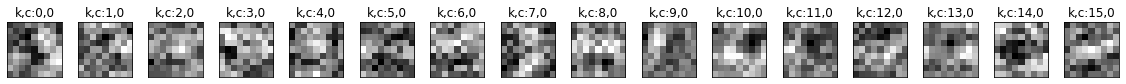

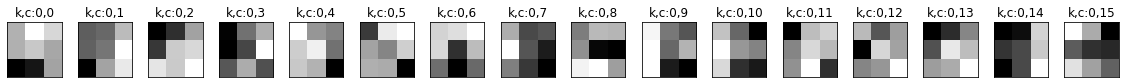

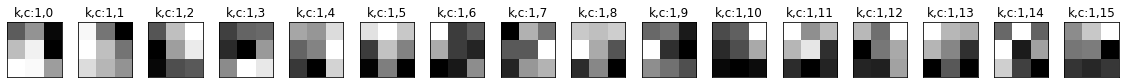

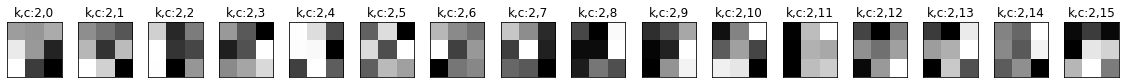

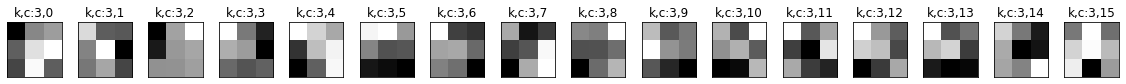

In [ ]:
print(model_cnn3)
show_kernels(model=model_cnn3, kernel_key="conv1.weight", img_max_num=64)
show_kernels(model=model_cnn3, kernel_key="conv2.weight", img_max_num=64)

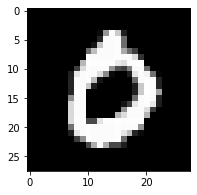

conv1 torch.Size([16, 28, 28])


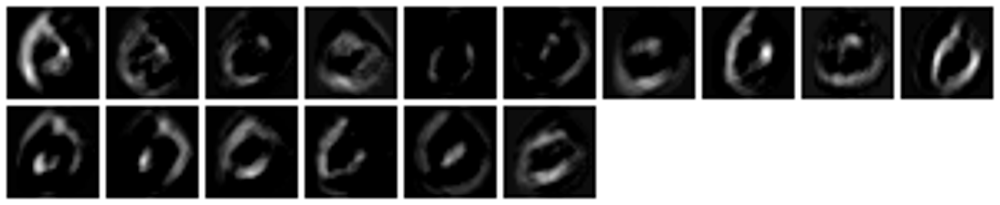

conv2 torch.Size([16, 28, 28])


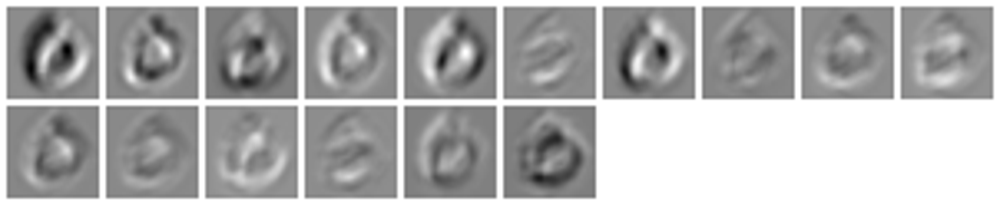

In [ ]:
input, label = test_set_MNIST[3]  # This index selects the input image
input = (input + 1) / 2
show_image(input.squeeze(0), imgtype="tensor", figsize=(3,3))

extractor = feature_extraction.create_feature_extractor(model_cnn3, ["conv1", "conv2"])
features = extractor(input.to(device))

show_features(features)

---
# **Multiclass classification of CIFER-10 using CNN**
---

In [ ]:
import torchvision.datasets as datasets         # for using CIFER-10 dataset
import torchvision.transforms as transforms     # Transforms
from torch.utils.data import DataLoader         # DataLoader

### Transforms
transform_for_VGG16_train = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

transform_for_VGG16_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

### Dataset
data_root = './data'

train_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform_for_VGG16_train
)

test_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform_for_VGG16_test
)


class_names_CIFAR10 = ('airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck')

### DataLoader
batch_size = 50

train_loader_CIFAR10 = DataLoader(
    train_set_CIFAR10,
    batch_size = batch_size,
    shuffle = True
)

test_loader_CIFAR10 = DataLoader(
    test_set_CIFAR10,
    batch_size = batch_size,
    shuffle = False
)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 🤔**Exercise 1.5** 

Implement any CNN model and train it using the CIFAR-10 dataset. Note that CIFAR-10 images are 32x32 color images (3 channels).

Consider the structure of the model so that the recognition accuracy is as high as possible. See the following website for the CIFAR-10 dataset.

https://www.cs.toronto.edu/~kriz/cifar.html


In [ ]:
import torchvision.datasets as datasets         # for using CIFER-10 dataset
import torchvision.transforms as transforms     # Transforms
from torch.utils.data import DataLoader         # DataLoader

### Implement Transforms -----------------------------------
transform_for_CNN = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])


###---------------------------------------------------------


### Implement Dataset (both for training and testing) ------
data_root = './data'
# training dataset
train_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = True,
    download = True,
    transform = transform_for_CNN)

# test dataset
test_set_CIFAR10 = datasets.CIFAR10(
    root = data_root,
    train = False,
    download = True,
    transform = transform_for_CNN)


###---------------------------------------------------------


class_names_CIFAR10 = ('airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck')


### Implement DataLoader  (both for training and testing) ----
batch_size = 100

# DataLoader for training data (with shuffle)
train_loader_CIFAR10 = DataLoader( train_set_CIFAR10, batch_size = batch_size, shuffle = True)

# DataLoader for test data (without shuffle)
test_loader_CIFAR10 = DataLoader( test_set_CIFAR10,  batch_size = batch_size, shuffle = False) 


###-----------------------------------------------------------


import torch.nn as nn
import torch.optim as optim


class Model_CNN4(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.relu = nn.ReLU(inplace=True) # inplace = If set to True, the variable will be overwritten directly to save memory.
        self.maxpool = nn.MaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(4096, 64) # Linear 1 input is 4096 = 16 * 16 * 16
        self.l2 = nn.Linear(64, 10)
        
        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool)
        
        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2)
   
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model_cnn4 = Model_CNN4()
model_cnn4 = model_cnn4.to(device) # Send the model to GPU

# Loss: Sortmax with Cross-entropy
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer_cnn4 = optim.SGD(model_cnn4.parameters(), lr=0.01)  # SGD, lr = learning rate
optimizer_cnn4 = optim.Adam(model_cnn4.parameters(), lr=0.001) # Adam, lr = learning rate

# for loss and accuracy recording
history_cnn4 = np.zeros((0,5))

summary(model_cnn4, (50000,3,32,32), depth=2)

Files already downloaded and verified
Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
Model_CNN4                               [50000, 10]               --
├─Sequential: 1-1                        [50000, 16, 16, 16]       2,320
│    └─Conv2d: 2-1                       [50000, 16, 32, 32]       448
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-2                         [50000, 16, 32, 32]       --
├─Sequential: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [50000, 16, 32, 32]       2,320
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-4                         [50000, 16, 32, 32]       --
├─Sequential: 1-5                        --                        (recursive)
│    └─MaxPool2d: 2-5                    [50000, 16, 16, 16]       --
├─Flatten: 1-6                           [50000, 4096]             --
├─Sequential: 1-7                        [

In [ ]:
num_epochs = 10    # The number of learning loop

history_cnn4 = fit(
    model = model_cnn4,
    optimizer = optimizer_cnn4,
    criterion = criterion,
    num_epochs = num_epochs,
    train_loader = train_loader_CIFAR10,
    test_loader = test_loader_CIFAR10,
    device = device,
    history = history_cnn4)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.01506 acc: 0.45850 val_loss: 0.01270, val_acc: 0.54290


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.01169 acc: 0.58526 val_loss: 0.01132, val_acc: 0.59830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.01031 acc: 0.63698 val_loss: 0.01060, val_acc: 0.62250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00930 acc: 0.67420 val_loss: 0.01015, val_acc: 0.64460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00853 acc: 0.70014 val_loss: 0.00993, val_acc: 0.65030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00793 acc: 0.72228 val_loss: 0.00984, val_acc: 0.65470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00734 acc: 0.74254 val_loss: 0.01010, val_acc: 0.65610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00680 acc: 0.75982 val_loss: 0.00980, val_acc: 0.66320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00631 acc: 0.77798 val_loss: 0.01062, val_acc: 0.65220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00587 acc: 0.79304 val_loss: 0.01042, val_acc: 0.66060
